In [8]:
import numpy as np
import matplotlib.pyplot as plt

image_file = '../data/raw/pannuke/Fold 1/images/fold1/images.npy'
mask_file = '../data/raw/pannuke/Fold 1/masks/fold1/masks.npy'

images = np.load(image_file)
masks = np.load(mask_file)

sample_index = 0
sample_image = images[sample_index]
sample_mask = masks[sample_index]


In [9]:
types_path = '../data/raw/pannuke/Fold 1/images/fold1/types.npy' 
types = np.load(types_path)

print(f"Types shape: {types.shape}")
print(f"Unique types: {np.unique(types)}")

Types shape: (2656,)
Unique types: ['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic'
 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


In [10]:
single_masks = masks[:, :, :, -1]
single_masks = np.expand_dims(single_masks, axis=-1)
single_masks.shape

(2656, 256, 256)

In [11]:
np.save('single_mask.npy', single_masks)

In [12]:
types_file = '../data/raw/pannuke/Fold 1/images/fold1/types.npy'
types = np.load(types_file)
colon_indices = np.where(types == 'Colon')[0]

# Convert to list if needed
colon_indices_list = colon_indices.tolist()
colon_indices_list
len(colon_indices_list)

single_masks = single_masks[colon_indices_list]

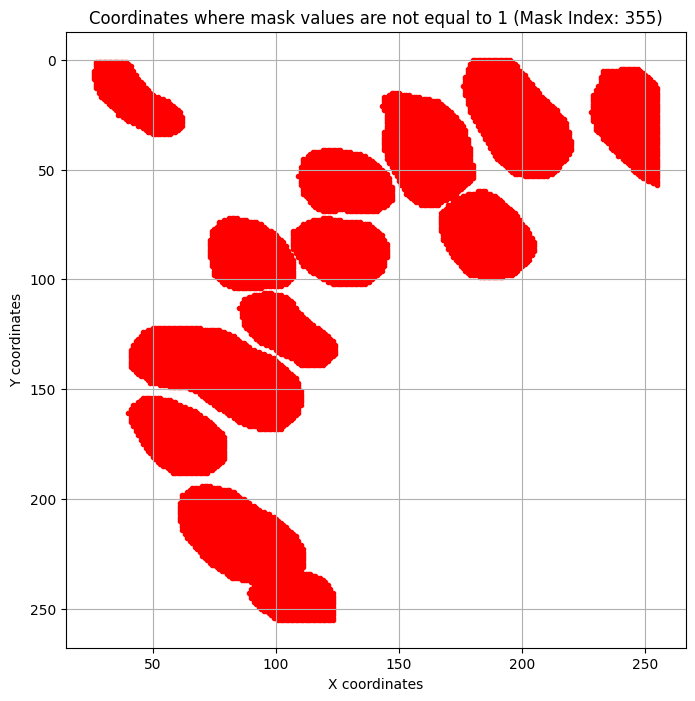

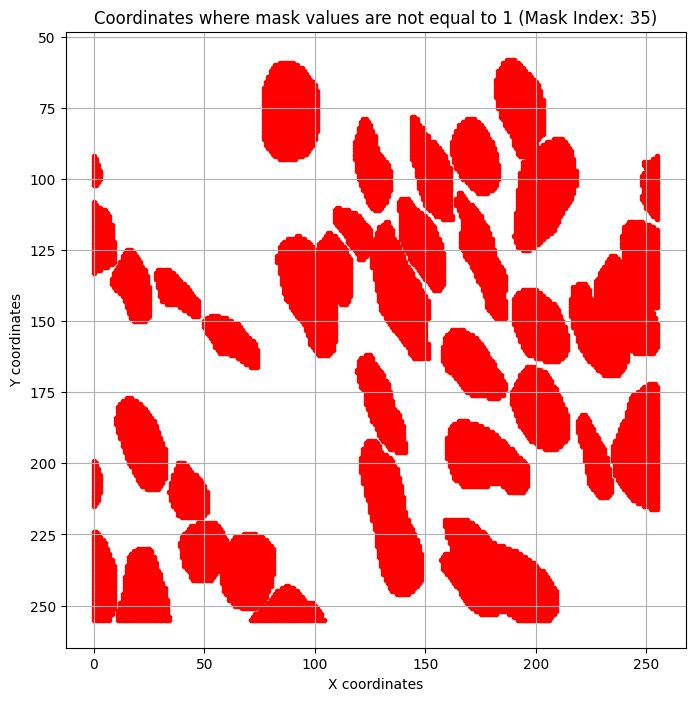

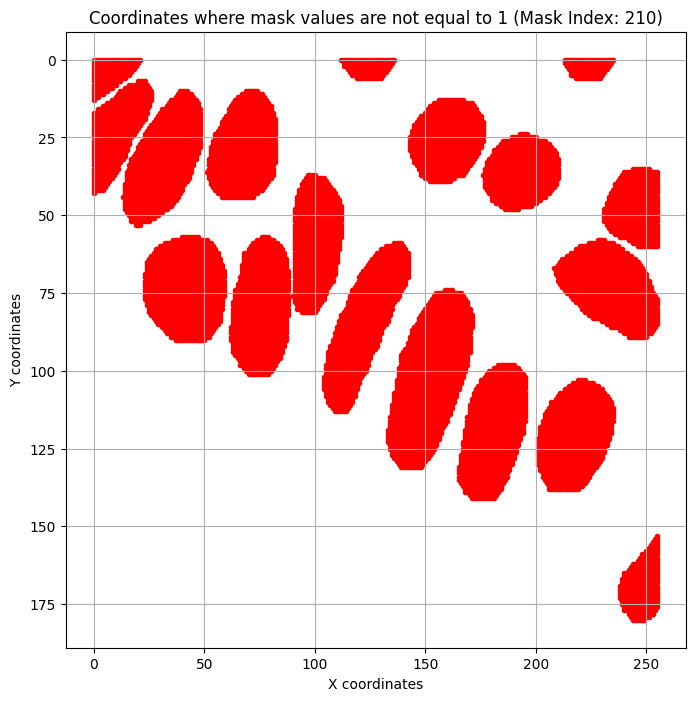

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(len(single_masks)), 3)

for i in random_indices:
    mask = single_masks[i]
    
    non_one_indices = np.where(mask != 1)
    y_coords, x_coords = non_one_indices

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, marker='.', color='red')
    plt.title(f'Coordinates where mask values are not equal to 1 (Mask Index: {i})')
    plt.xlabel('X coordinates')
    plt.ylabel('Y coordinates')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.grid(True)
    plt.show()

In [14]:
import cv2
import numpy as np
from sklearn.decomposition import PCA

cv2.imshow('Original Image', images[0])

def rgb_to_od(img):
    img = img.astype(np.float32)
    img[img == 0] = 1  # div by 0 case
    return -np.log(img / 255)

img_od = rgb_to_od(images[0])

reshaped_od = img_od.reshape((-1, 3))
pca = PCA(n_components=2)
pca.fit(reshaped_od)
stain_matrix = pca.components_.T

stains = np.dot(reshaped_od, np.linalg.pinv(stain_matrix).T)
stains = stains.reshape(img.shape[0], img.shape[1], -1)
target_means = np.array([0.5, 0.5])
target_stds = np.array([0.2, 0.2])
stains_normalized = (stains - np.mean(stains, axis=(0, 1))) / np.std(stains, axis=(0, 1))
stains_normalized = stains_normalized * target_stds + target_means
od_normalized = np.dot(stains_normalized.reshape((-1, 2)), stain_matrix.T)
od_normalized = od_normalized.reshape(img.shape)
img_reconstructed = np.exp(-od_normalized)
img_reconstructed = np.clip(img_reconstructed, 0, 1)
img_reconstructed = (img_reconstructed * 255).astype(np.uint8)
cv2.imshow('Reconstructed Image', img_reconstructed)


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Macenko for Pannuke
import cv2
import numpy as np
from sklearn.decomposition import PCA

def rgb_to_od(img):
    img = img.astype(np.float32)
    img[img == 0] = 1 
    return -np.log(img / 255)

def normalize_stains(image, target_means, target_stds):
    # Convert RGB to Optical Density (OD)
    img_od = rgb_to_od(image)

    # Reshape for PCA
    reshaped_od = img_od.reshape((-1, 3))

    # Perform PCA to find the stain matrix
    pca = PCA(n_components=2)
    pca.fit(reshaped_od)
    stain_matrix = pca.components_.T

    # Calculate stains
    stains = np.dot(reshaped_od, np.linalg.pinv(stain_matrix).T)
    stains = stains.reshape(img_od.shape[0], img_od.shape[1], -1)

    # Normalize stains
    stains_normalized = (stains - np.mean(stains, axis=(0, 1))) / np.std(stains, axis=(0, 1))
    stains_normalized = stains_normalized * target_stds + target_means

    # Convert back to OD space
    od_normalized = np.dot(stains_normalized.reshape((-1, 2)), stain_matrix.T)
    od_normalized = od_normalized.reshape(image.shape)

    # Reconstruct image from OD
    img_reconstructed = np.exp(-od_normalized)
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    img_reconstructed = (img_reconstructed * 255).astype(np.uint8)

    return img_reconstructed

# Example images array
# images = [cv2.imread('path_to_image1.jpg'), cv2.imread('path_to_image2.jpg'), ...]
images = images[colon_indices_list]
images_macenko = []

# Define target means and stds
target_means = np.array([0.5, 0.5])
target_stds = np.array([0.2, 0.2])

# Process and display all images
for i, image in enumerate(images):
    img_reconstructed = normalize_stains(image, target_means, target_stds)
    images_macenko.append(img_reconstructed)




In [ ]:
#Macenko for Visium image

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(images[colon_indices_list], single_masks, test_size=0.2, random_state=40)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(382, 256, 256, 3)
(96, 256, 256, 3)
(382, 256, 256)
(96, 256, 256)


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    return model


In [35]:
model = unet_model()

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_26[0][0],

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 523s 22s/step - accuracy: 0.6812 - loss: 3.7276 - val_accuracy: 0.7401 - val_loss: 4.1528
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 499s 21s/step - accuracy: 0.7614 - loss: 3.8135 - val_accuracy: 0.7407 - val_loss: 4.1423
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 503s 21s/step - accuracy: 0.7609 - loss: 3.8207 - val_accuracy: 0.7407 - val_loss: 4.1423
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 499s 21s/step - accuracy: 0.7589 - loss: 3.8517 - val_accuracy: 0.7407 - val_loss: 4.1423
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 504s 21s/step - accuracy: 0.7730 - loss: 3.6274 - val_accuracy: 0.7407 - val_loss: 4.1423


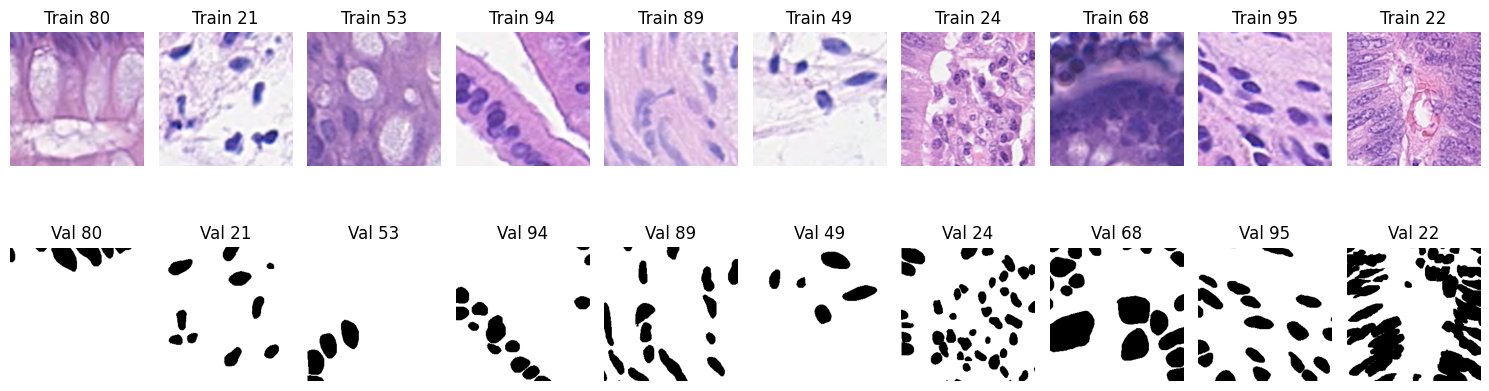

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(X_train, Y_train, num_samples=10):
    # Generate random indices
    random_indices = np.random.choice(len(X_train), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    # Plot random samples from X_train
    for i, idx in enumerate(random_indices):
        ax = axes[0, i]
        ax.imshow(X_train[idx].astype(int), cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Train {idx}")
        ax.axis('off')

    # Plot random samples from Y_train
    for i, idx in enumerate(random_indices):
        ax = axes[1, i]
        ax.imshow(Y_train[idx], cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Val {idx}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_random_samples(X_val, Y_val)


In [38]:
model.save('../data/processed/pannuke/only_colon_3e.h5')

In [16]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

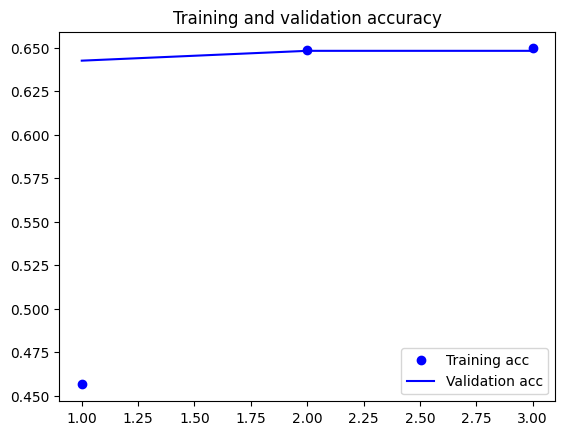

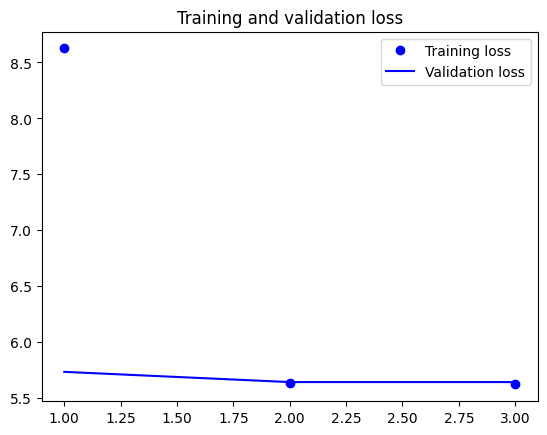

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


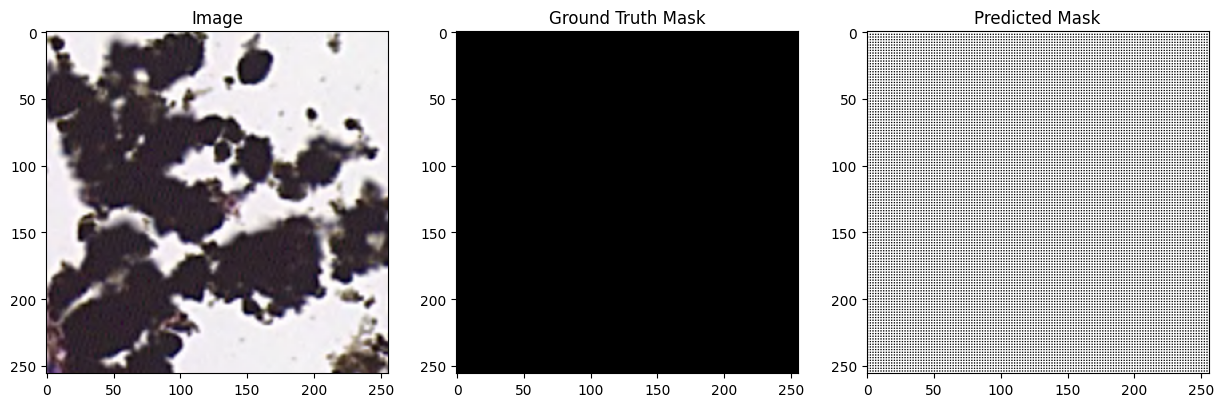

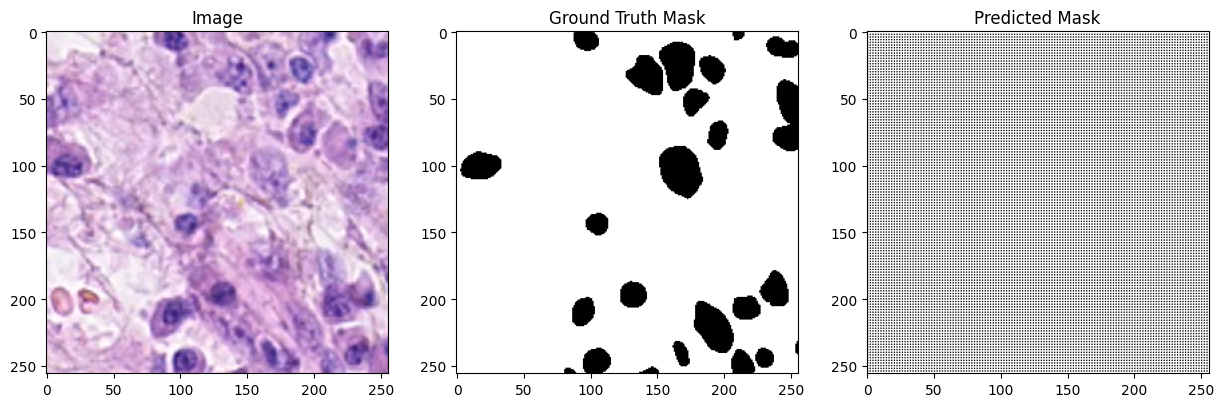

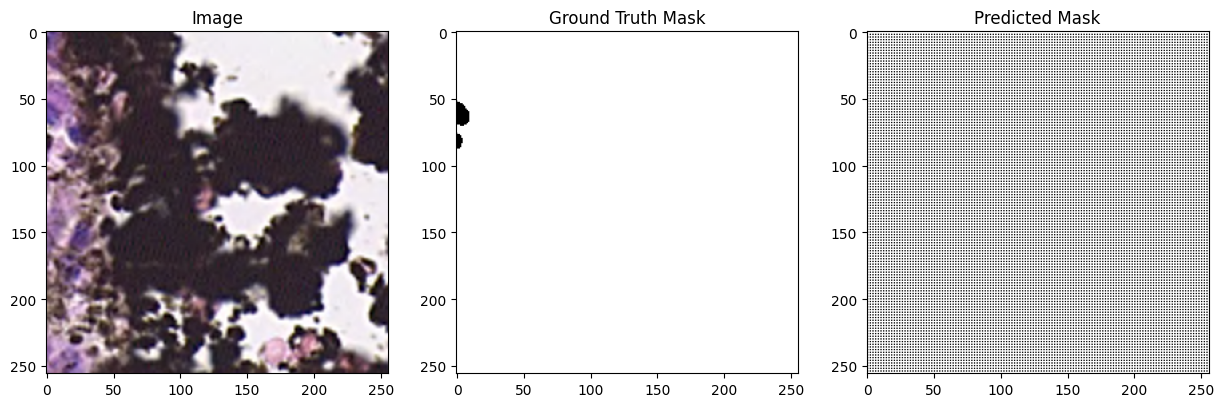

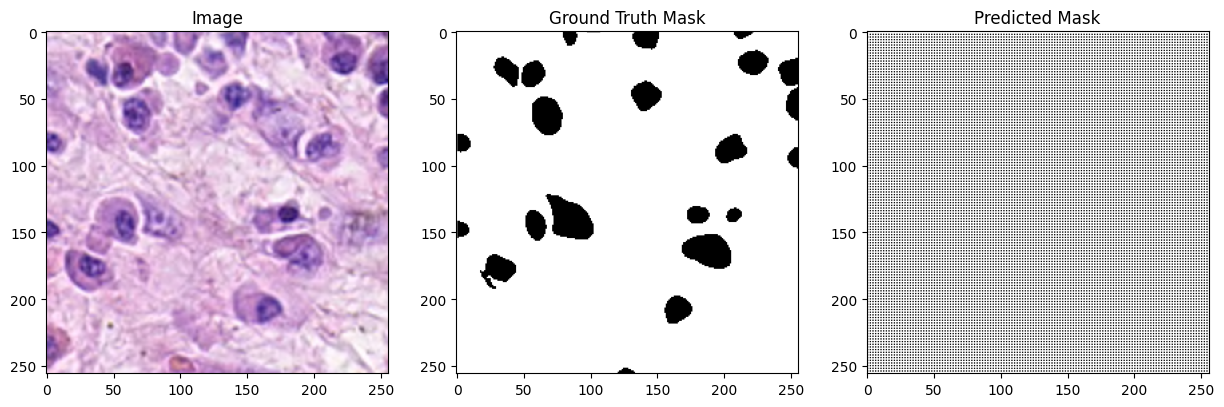

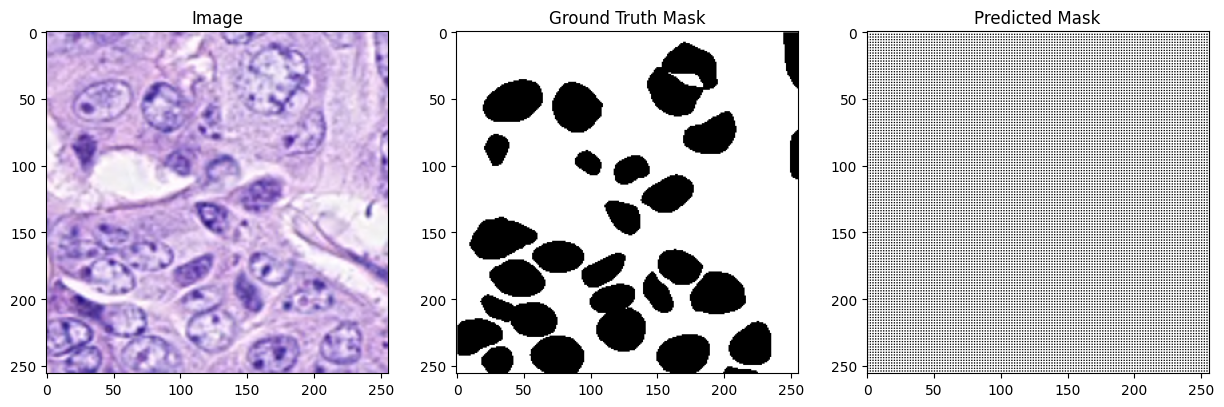

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X_test = images[750:760]
masks = np.load(mask_file)
masks = masks[:, :, :, -1]
Y_test = masks[750:760]

# TODO Normalize? i did not do it yet
# X_test = X_test / 255.0

Y_pred = model.predict(X_test)

# Reshape predictions to match ground truth
Y_pred_thresholded = (Y_pred > 0.5).astype(np.uint8)

# Remove the last channel dimension
Y_pred_thresholded = np.squeeze(Y_pred_thresholded, axis=-1)


def plot_sample(image, true_mask, pred_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.astype(int))
    axes[0].set_title('Image')
    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    plt.show()

for i in range(5):
    plot_sample(X_test[i], Y_test[i], Y_pred_thresholded[i])


In [26]:

import sys
sys.path.append('../utils')
import os
import image_cropp_utils

from image_cropp_utils import read_image

dir_base = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/'
filename = 'p5_cropped_image_overlap_comparison.btf'
img = read_image(dir_base + filename)

In [113]:
print(img.astype(float))

[[[166.  33. 138.]
  [147.  14. 119.]
  [153.  16. 122.]
  ...
  [239. 107. 209.]
  [218.  87. 193.]
  [171.  42. 161.]]

 [[209.  77. 179.]
  [189.  57. 158.]
  [184.  48. 150.]
  ...
  [240. 110. 210.]
  [223.  94. 197.]
  [187.  58. 176.]]

 [[236. 105. 201.]
  [227.  96. 192.]
  [214.  83. 179.]
  ...
  [244. 116. 213.]
  [231. 105. 205.]
  [200.  71. 187.]]

 ...

 [[226. 131. 215.]
  [224. 124. 210.]
  [214. 109. 201.]
  ...
  [220.  97. 201.]
  [223.  95. 204.]
  [220.  89. 201.]]

 [[241. 158. 230.]
  [238. 150. 226.]
  [228. 133. 217.]
  ...
  [216.  96. 196.]
  [221.  95. 202.]
  [224.  94. 203.]]

 [[251. 177. 238.]
  [254. 173. 240.]
  [244. 158. 233.]
  ...
  [210.  90. 188.]
  [216.  91. 195.]
  [218.  91. 198.]]]


In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

def extract_patches(image, patch_size=(256, 256), overlap=0.5):
    patches = []
    stride = int(patch_size[0] * (1 - overlap))
    for y in range(0, image.shape[0] - patch_size[0] + 1, stride):
        for x in range(0, image.shape[1] - patch_size[1] + 1, stride):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            patches.append((patch, (x, y)))
    return patches

def plot_patch_vs_mask(original_patch, predicted_mask_patch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_patch)
    axes[0].set_title('Original Patch')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask_patch.squeeze(), cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()

large_image = img

patch_size = (256, 256)
overlap = 0.5
patches = extract_patches(large_image, patch_size=patch_size, overlap=overlap)

model = tf.keras.models.load_model('/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/pannuke/only_colon_3e.h5')
predictions = []
predictions_thresholded = []

for patch, position in patches:
    patch = patch[np.newaxis, ...]
    pred = model.predict(patch.astype(int))
    predictions.append((pred.squeeze(), position))
    pred = (pred > 0.5).astype(np.uint8)  # threshold prediction
    predictions_thresholded.append((pred.squeeze(), position))  # remove batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
predictions

[(array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 0., ..., 1., 0., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 1., 0., ..., 1., 0., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
  (0, 0)),
 (array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 0., ..., 1., 0., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 1., 0., ..., 1., 0., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
  (128, 0)),
 (array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 0., ..., 1., 0., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 1., 0., ..., 1., 0., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
  (256, 0)),
 (array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 0., ..., 1., 0., 1.],
         ...,
         [1., 1.

In [30]:
predictions_thresholded
pred_min = np.min(predictions_thresholded[0][0])
pred_max = np.max(predictions_thresholded[0][0])
print(pred_max)
print(pred_min)
predictions_thresholded

1
0


[(array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 0, ..., 1, 0, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [0, 1, 0, ..., 1, 0, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (0, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 0, ..., 1, 0, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [0, 1, 0, ..., 1, 0, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (128, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 0, ..., 1, 0, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [0, 1, 0, ..., 1, 0, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (256, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 0, ..., 1, 0, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [0, 1, 0, ..., 1, 0, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (384, 0)),
 (array([[1, 1, 1,

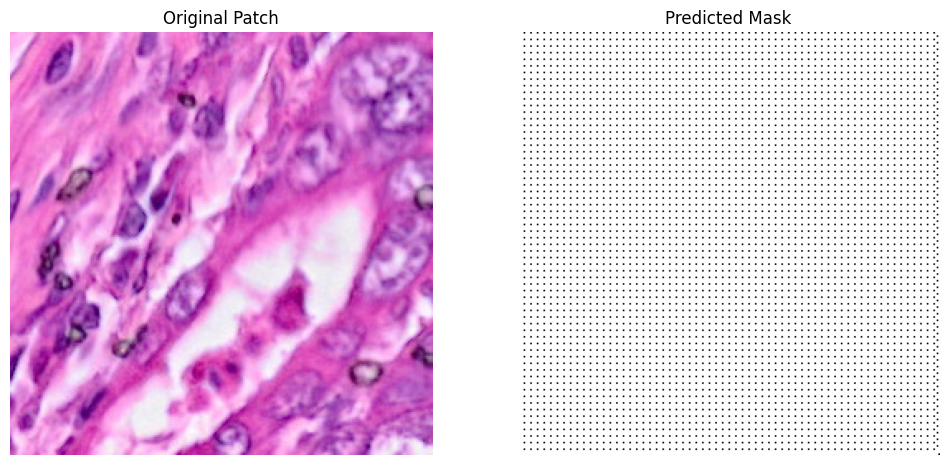

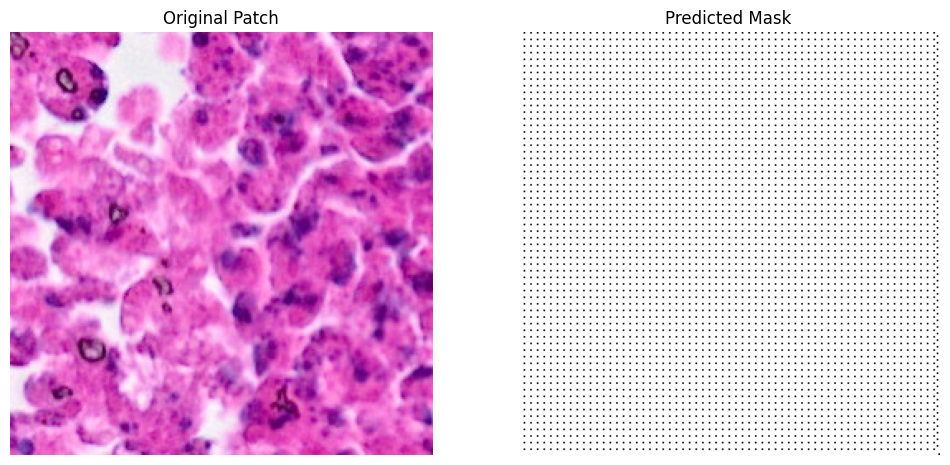

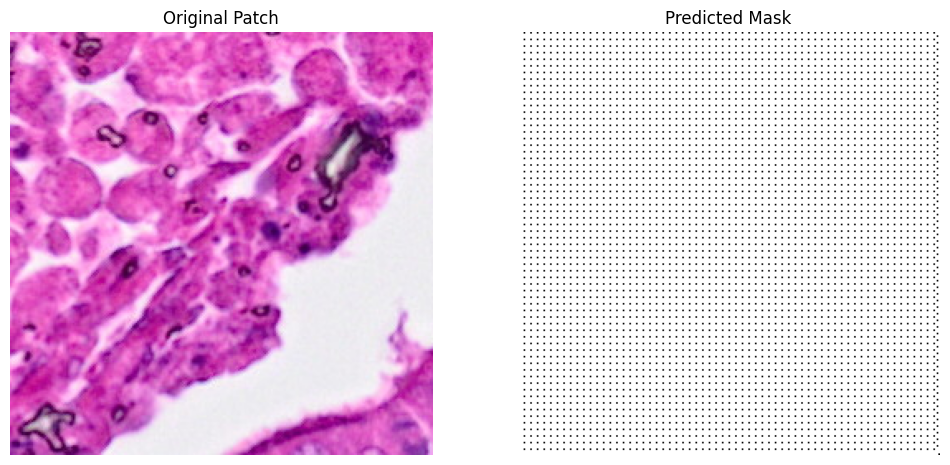

In [40]:
# 3 random patches
random_indices = random.sample(range(len(patches)), 3)
for i in random_indices:
    patch, _ = patches[i]
    pred, _ = predictions_thresholded[i]
    
    plot_patch_vs_mask(patch, pred)